In [54]:
import pandas as pd
from pathlib import Path


In [62]:
raw_dir = Path("../data/raw")

files = sorted(raw_dir.glob("api_data_aadhar_biometric_*.csv"))

df = pd.concat(
    [pd.read_csv(f) for f in files],
    ignore_index=True
)


In [63]:
df["date"] = pd.to_datetime(df["date"], format="%d-%m-%Y", errors="coerce")

df = df.dropna(subset=["date"]).copy()

df["total_bio_updates"] = (
    df["bio_age_5_17"] + df["bio_age_17_"]
)


In [64]:
daily = (
    df
    .groupby(["district", "date"], as_index=False)
    .agg(total_bio_updates=("total_bio_updates", "sum"))
)


In [65]:
baseline = (
    daily
    .groupby("district", as_index=False)
    .agg(
        mean_updates=("total_bio_updates", "mean"),
        std_updates=("total_bio_updates", "std")
    )
)


In [66]:
daily = daily.merge(
    baseline,
    on="district",
    how="left"
)

daily["z_score"] = (
    (daily["total_bio_updates"] - daily["mean_updates"])
    / daily["std_updates"]
)


In [67]:
Z_THRESHOLD = 4

daily["is_anomaly"] = daily["z_score"].abs() >= Z_THRESHOLD


In [71]:
anomalies = (
    daily[daily["is_anomaly"]]
    .sort_values("z_score", ascending=False)
    .reset_index(drop=True)
)

anomalies = anomalies[
    ["district", "date", "total_bio_updates", "mean_updates", "std_updates", "z_score"]
]

anomalies.to_csv(
    "../data/processed/district_anomalies.csv",
    index=False
)


In [73]:
top_district = (
    anomalies["district"]
    .value_counts()
    .idxmax()
)


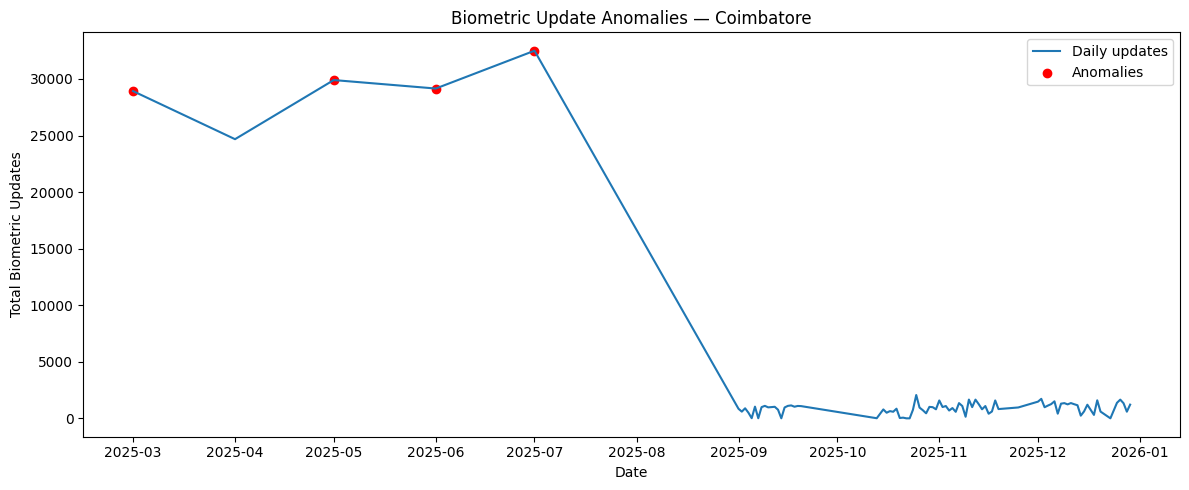

In [74]:
import matplotlib.pyplot as plt

plot_df = daily[daily["district"] == top_district]

plt.figure(figsize=(12, 5))
plt.plot(plot_df["date"], plot_df["total_bio_updates"], label="Daily updates")

plt.scatter(
    plot_df[plot_df["is_anomaly"]]["date"],
    plot_df[plot_df["is_anomaly"]]["total_bio_updates"],
    color="red",
    label="Anomalies"
)

plt.title(f"Biometric Update Anomalies — {top_district}")
plt.xlabel("Date")
plt.ylabel("Total Biometric Updates")
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
plt.savefig("../outputs/anomaly_plot_example.png", dpi=150)


<Figure size 640x480 with 0 Axes>

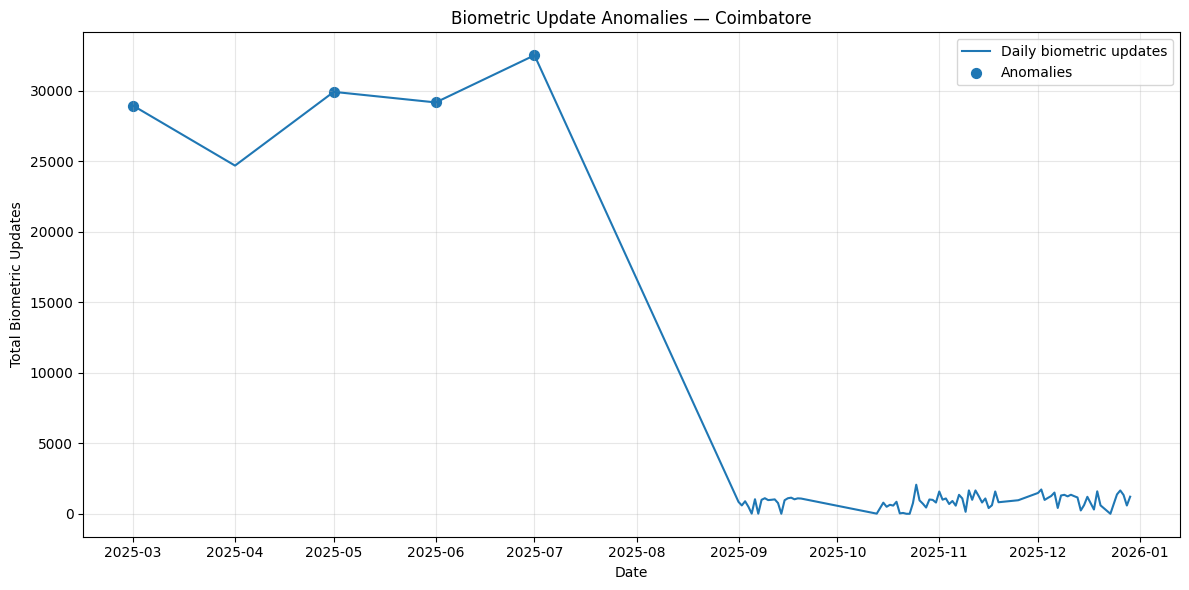

In [82]:
import matplotlib.pyplot as plt

# Select one district to visualize
district_name = "Coimbatore"

plot_df = daily[daily["district"] == district_name].sort_values("date")
anomaly_df = plot_df[plot_df["is_anomaly"]]

plt.figure(figsize=(12, 6))

# Line plot: daily biometric updates
plt.plot(
    plot_df["date"],
    plot_df["total_bio_updates"],
    label="Daily biometric updates"
)

# Scatter plot: anomalies
plt.scatter(
    anomaly_df["date"],
    anomaly_df["total_bio_updates"],
    s=50,
    label="Anomalies"
)

plt.title(f"Biometric Update Anomalies — {district_name}")
plt.xlabel("Date")
plt.ylabel("Total Biometric Updates")
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig("../outputs/biometric_anomaly_plot_coimbatore.png", dpi=300)
plt.show()
